## POS tagging using Vanilla Viterbi and Modified Viterbi

In this Project, I have used vanilla Viterbi as well as modified version of the Viterbi algorithm to solve the problem of unknown words. Determining correctly the PoS tags for unknown words happens arbitrarily in Vanilla Viterbi and this results in reduced accuracy. The idea is to develop different approaches to improve the accuracy while determining POS tags for unknown words.
<br><br>
The modified version of Viterbi includes three approaches explained in the code in comments, along with respective approach's accuracies on the test data.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# nltk.download('treebank')
# nltk.download('universal_tagset')

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
print(len(nltk_data))

3914


In [5]:
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [6]:
# Splitting into train and test
#random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05, random_state = 1234)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('This', 'DET'), ('year', 'NOUN'), (',', '.'), ('the', 'DET'), ('average', 'NOUN'), ('of', 'ADP'), ('daily', 'ADJ'), ('contracts', 'NOUN'), ('traded', 'VERB'), ('*', 'X'), ('totaled', 'VERB'), ('9,118', 'NUM'), (',', '.'), ('up', 'ADP'), ('from', 'ADP'), ('4,645', 'NUM'), ('a', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), ('and', 'CONJ'), ('from', 'ADP'), ('917', 'NUM'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.')], [('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('now', 'ADV'), ('has', 'VERB'), ('45', 'NUM'), ('banks', 'NOUN'), ('and', 'CONJ'), ('$', '.'), ('12.5', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('assets', 'NOUN'), (',', '.'), ('announced', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('the', 'DET'), ('Peoria', 'NOUN'), (',', '.'), ('Ill.', 'NOUN'), (',', '.'), ('bank', 'NOUN'), ('holding', 'VERB'), ('company', 'NOUN'), ('in', 'ADP'), ('January',

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))
train_tagged_words

95799


[('This', 'DET'),
 ('year', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('average', 'NOUN'),
 ('of', 'ADP'),
 ('daily', 'ADJ'),
 ('contracts', 'NOUN'),
 ('traded', 'VERB'),
 ('*', 'X'),
 ('totaled', 'VERB'),
 ('9,118', 'NUM'),
 (',', '.'),
 ('up', 'ADP'),
 ('from', 'ADP'),
 ('4,645', 'NUM'),
 ('a', 'DET'),
 ('year', 'NOUN'),
 ('earlier', 'ADJ'),
 ('and', 'CONJ'),
 ('from', 'ADP'),
 ('917', 'NUM'),
 ('in', 'ADP'),
 ('1984', 'NUM'),
 ('.', '.'),
 ('First', 'NOUN'),
 ('of', 'ADP'),
 ('America', 'NOUN'),
 (',', '.'),
 ('which', 'DET'),
 ('*T*-1', 'X'),
 ('now', 'ADV'),
 ('has', 'VERB'),
 ('45', 'NUM'),
 ('banks', 'NOUN'),
 ('and', 'CONJ'),
 ('$', '.'),
 ('12.5', 'NUM'),
 ('billion', 'NUM'),
 ('*U*', 'X'),
 ('in', 'ADP'),
 ('assets', 'NOUN'),
 (',', '.'),
 ('announced', 'VERB'),
 ('an', 'DET'),
 ('agreement', 'NOUN'),
 ('*', 'X'),
 ('to', 'PRT'),
 ('acquire', 'VERB'),
 ('the', 'DET'),
 ('Peoria', 'NOUN'),
 (',', '.'),
 ('Ill.', 'NOUN'),
 (',', '.'),
 ('bank', 'NOUN'),
 ('holding', 'VERB'),
 ('c

In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['This',
 'year',
 ',',
 'the',
 'average',
 'of',
 'daily',
 'contracts',
 'traded',
 '*']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12073


In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)
T_count = [pair[1] for pair in train_tagged_words]

12
{'PRON', 'X', 'NOUN', 'PRT', 'ADV', 'ADP', '.', 'DET', 'NUM', 'CONJ', 'ADJ', 'VERB'}


#### Emission Probability

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transitional Probability

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
# t1 is followed by t2.

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# Lets try to derive some insights from transition probability for few of the POS tags.
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'PRON'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('VERB', 'ADJ'))
print(t2_given_t1('VERB', 'PRON'))
print(t2_given_t1('VERB', 'DET'))

# Observations:
#  1. ADJ is followed by NOUN almost ~65% of the times.
#  2. DET is followed by NOUN almost ~60% of times.
#  3. PRON followed by another PRON is very rare.
#  4. VERB followed by ADJ is also rare.

(4235, 6063)
(543, 2619)
(5281, 8269)
(1431, 12910)
(20, 2619)
(4020, 27471)
(74, 6063)
(1278, 2619)
(327, 8269)


In [15]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('ADJ', '.'))
print(t2_given_t1('CONJ', '.'))
print(t2_given_t1('PRON', '.'))
print(t2_given_t1('NUM', '.'))
print(t2_given_t1('ADP', '.'))
print(t2_given_t1('X', '.'))
print(t2_given_t1('PRT', '.'))
print(t2_given_t1('ADV', '.'))

# From this we understand that most of the times, 'NOUN' is the first word of a sentence in 
# the given corpus.

(1928, 11130)
(988, 11130)
(2483, 11130)
(497, 11130)
(643, 11130)
(732, 11130)
(897, 11130)
(1006, 11130)
(304, 11130)
(26, 11130)
(578, 11130)


In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
tags_matrix

array([[7.63650239e-03, 9.39289778e-02, 2.07331046e-01, 1.18365791e-02,
        3.28369625e-02, 2.32913326e-02, 4.04734649e-02, 9.16380342e-03,
        7.25467736e-03, 4.58190171e-03, 7.36922473e-02, 4.87972498e-01],
       [5.63291125e-02, 7.48417750e-02, 6.21835440e-02, 1.84651896e-01,
        2.61075944e-02, 1.44936711e-01, 1.62816450e-01, 5.41139245e-02,
        2.68987333e-03, 1.07594933e-02, 1.64556969e-02, 2.04113930e-01],
       [4.76866495e-03, 2.92308256e-02, 2.64897525e-01, 4.39736433e-02,
        1.71817560e-02, 1.77023038e-01, 2.39306912e-01, 1.32503370e-02,
        9.53732990e-03, 4.22627516e-02, 1.22310799e-02, 1.46336138e-01],
       [1.79153103e-02, 1.40065150e-02, 2.47882739e-01, 1.95439742e-03,
        9.77198686e-03, 2.11726390e-02, 4.16938104e-02, 9.96742696e-02,
        5.66775240e-02, 2.28013028e-03, 8.40390846e-02, 4.02931601e-01],
       [1.53997382e-02, 2.32634339e-02, 3.11271306e-02, 1.47444298e-02,
        8.12581927e-02, 1.18610747e-01, 1.34665787e-01, 6.84

In [18]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRON,X,NOUN,PRT,ADV,ADP,.,DET,NUM,CONJ,ADJ,VERB
PRON,0.007637,0.093929,0.207331,0.011837,0.032837,0.023291,0.040473,0.009164,0.007255,0.004582,0.073692,0.487972
X,0.056329,0.074842,0.062184,0.184652,0.026108,0.144937,0.162816,0.054114,0.002690,0.010759,0.016456,0.204114
NOUN,0.004769,0.029231,0.264898,0.043974,0.017182,0.177023,0.239307,0.013250,0.009537,0.042263,0.012231,0.146336
PRT,0.017915,0.014007,0.247883,0.001954,0.009772,0.021173,0.041694,0.099674,0.056678,0.002280,0.084039,0.402932
ADV,0.015400,0.023263,0.031127,0.014744,0.081258,0.118611,0.134666,0.068480,0.031455,0.006881,0.129751,0.344364
ADP,0.070203,0.035048,0.322893,0.001491,0.013849,0.016512,0.039842,0.322893,0.062001,0.000959,0.105785,0.008522
.,0.065768,0.027314,0.223091,0.002336,0.051932,0.090386,0.094070,0.173226,0.080593,0.057772,0.044654,0.088769
DET,0.003749,0.046197,0.638650,0.000242,0.012698,0.009191,0.017777,0.005442,0.022373,0.000484,0.203652,0.039545
NUM,0.001486,0.210464,0.354637,0.027051,0.002973,0.035672,0.115933,0.002973,0.184899,0.013377,0.032402,0.018133
CONJ,0.057369,0.008862,0.348881,0.005131,0.055970,0.052705,0.033116,0.118470,0.041511,0.000466,0.118937,0.158582


In [19]:
tags_df.loc['.', :]

PRON    0.065768
X       0.027314
NOUN    0.223091
PRT     0.002336
ADV     0.051932
ADP     0.090386
.       0.094070
DET     0.173226
NUM     0.080593
CONJ    0.057772
ADJ     0.044654
VERB    0.088769
Name: ., dtype: float32

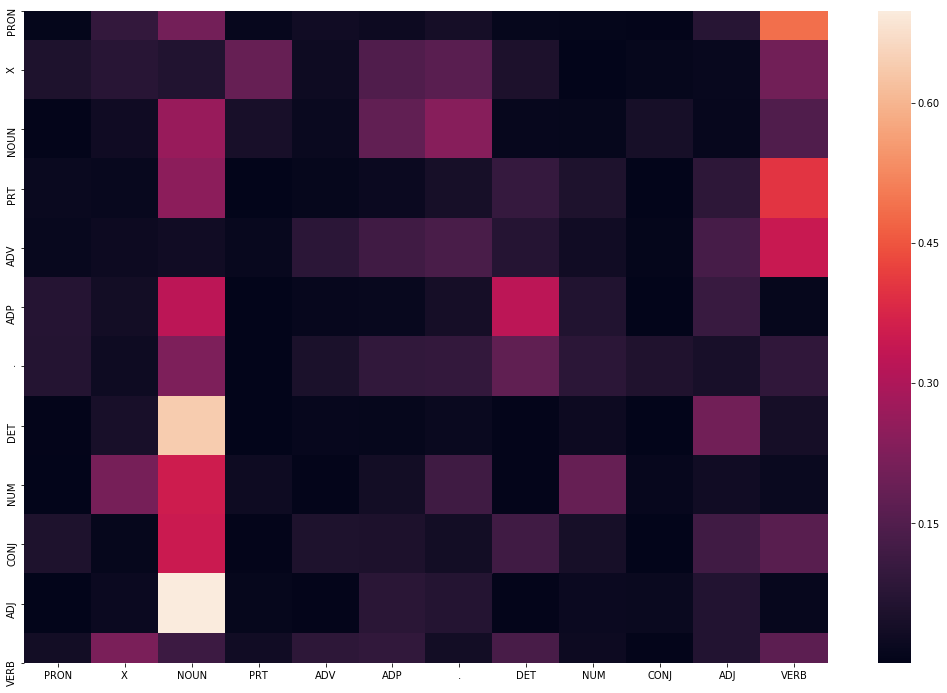

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

Note that NOUN and ADJ, as well as NOUN and DET, are highly correlated.

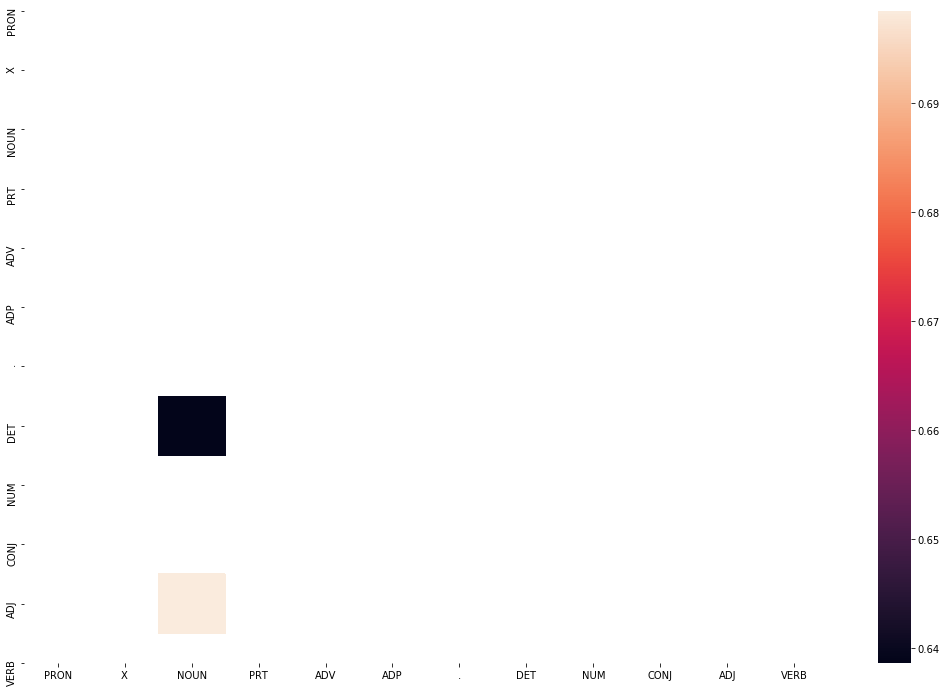

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [22]:
len(train_tagged_words)

95799

Now we shall build our Viterbi based POS tagger algorithm.

<font color = "orange">**Note we are incorporating the three different approaches (approach1, approach2, approach3) within same Viterbi function.**</font>

We will add an extra parameter called "approach" in the function which by default would run as 'vanilla'.

<font color = "brown">The function description used for the approaches - '***approach1***', '***approach2***' and '***approach3***' is defined later.</font>

We shall then make use of the different approaches to evaluate the validation dataset, and compare accuracies.

In [23]:
# Viterbi Heuristic

# Below Viterbi function incorporates "Vanilla", "Approach1", "Approach2", and "Approach3"
# Pre- requirement for all the three approaches - the unknown word must not be in the corpus i.e. in list tokens

def Viterbi(words, approach = 'vanilla', train_bag = train_tagged_words):

    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):

        if word not in tokens:

    ########### APPROACH 1 - tagging unknown word with most freq tag ###########
            if approach == 'approach1':
                state.append(assign_freq_tag())
                continue
    #__________________________________________________________________________#


    ##################### APPROACH 3 - Rule based tagging ######################
            elif approach == 'approach3':
                if key == 0:
                    state.append(assign_freq_tag())
                    continue
                else:
                    state.append(rule_based_tagging(words[key], words[key-1]))
                    continue
    #__________________________________________________________________________#

        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            

    ###### APPROACH 2 - adjusting emission probability to non zero value #######
            if approach == 'approach2':
                if word not in tokens:
                    emission_p = adjust_emission_p()
    #__________________________________________________________________________#


            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Solve the problem of unknown words

We shall use three approaches for Unknown word tagging:

1. Approach1: Find out the most frequent tag in the corpus, and substitute the Unknown words with 'NOUN' tags.
<br><br>
2. Approach2: Adjust emission probability with a small non-zero value instead of zero, and assign POS tag based on the max. of product of the adjusted emission prob. and transition prob.
<br><br>
3. Approach3: Use rule based technique to assign tags based on some rules such as tagging words ending with 'ing', 'ed', containing numbers etc.

##### APPROACH 1 (identifying most freq tag and substituting it for Unknown words)

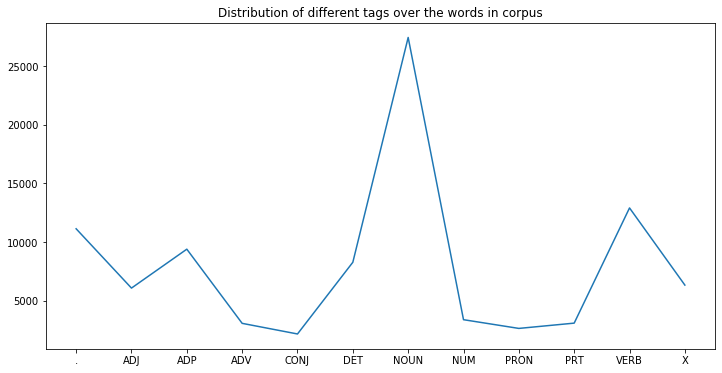



 Counter({'NOUN': 27471, 'VERB': 12910, '.': 11130, 'ADP': 9387, 'DET': 8269, 'X': 6320, 'ADJ': 6063, 'NUM': 3364, 'PRT': 3070, 'ADV': 3052, 'PRON': 2619, 'CONJ': 2144})


In [24]:
# Let us see how the different tags are distributed in the given corpus

from collections import Counter
T_counter = Counter(T_count)

T_count_list = sorted(T_counter.items()) # sorted by key, return a list of tuples

x, y = zip(*T_count_list) # unpack a list of pairs into two tuples

plt.figure(figsize=(12,6))
plt.title('Distribution of different tags over the words in corpus')
plt.plot(x, y)
plt.show()

# for quick reference to actual numbers
print('\n\n',T_counter)

From the above tag distribution, we find that the tag 'NOUN' has the highest occurrence in given corpus. 

In [25]:
# Lets write a function that returns the most frequent tag

def assign_freq_tag():
    max_freq_tag_count = max(T_counter.values())
    most_freq_tag = [k for k,v in T_counter.items() if v == max_freq_tag_count]
    return most_freq_tag[0]

# In the given corpus, as per the above plot, the above function shall return 'NOUN' as the tag 
# to be assigned to the unknown words.

##### APPROACH 2 (making emission prob. to small non zero value, and deciding the tags based on transitional probabaility)

In [26]:
# we shall assign a very small value to emission_p in case it is zero due to the word not being 
# present In the corpus

def adjust_emission_p():
    # assigning a small non-zero value to emission prob. (say 0.001)
    adjusted_emission_p = 0.001
    return adjusted_emission_p

##### APPROACH 3 (introducing few rules to tag the unknown words)

In [27]:
# lets put some rules for tagging based on the words ending with 'ing' or 'ed' or containing digits etc.
def rule_based_tagging(word, prev_word):
    past_participle_verb_indicator = ['had', 'has', 'have']

    if re.match('\*+\w*\*+', word):
        return 'X'        # from the train tagged words, we find that words containing multiple '*' with numbers or alphabets are tagged as 'X'
    
    elif re.match('\d*[.,]*\d+',word):
        return 'NUM'      # words containg numbers (integers or decimal) 
    
    # elif re.match('\w*-*\w*', word):
    #     return 'ADJ'      # Hyphens are most commonly used in compound adjectives. 
    #                       #These are words made up of a noun and an adjective, a noun and a 
    #                       #participle, or an adjective and a participle.
    
#     elif word.startswith(('un','dis')):
#         return 'ADJ'      # words containing prefix such as 'un', 'dis' are mostly adjectives
#                           # we shall restrict ourselves to just these two, as changing more might
#                           # begin to deteriorate accuracy
#                           # e.g. unsure, unsophisticated, disarm, dislike etc.
    
    elif word.endswith(('ing', 'ed')):
        return 'VERB'     # words ending with 'ing' are mostly the continuous for of a VERB
                          # words ending with 'ed' are mostly the past form of a VERB
                          # e.g. -> working, eating, swimming, worked, swimmed etc.
    
    elif prev_word in past_participle_verb_indicator:
        return 'VERB'     # words having 'had', 'has', 'have' as their previous word, are mostly
                          # VERB.
                          # I have done my work. -> Here done is VERB
    
    else:
        return 'NOUN'     # if no rules are satisfied, simply tag it as 'NOUN' since "NOUN" is 
                          # the most frequent tag.
    
    # There are many other rules that we can add, but to avoid the risk of overfitting, we'd restrict
    # ourselves to few rules only.

#### Evaluating tagging accuracy

In [28]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# list of tagged words
test_set_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print(test_set_base)
print(test_tagged_words)

[('Ruth', 'NOUN'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'NOUN'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'X'), ('trade', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'NOUN'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'NOUN'), ('with', 'ADP'), ('Buick', 'NOUN'), ('cars', 'NOUN'), ('or', 'CONJ'), (

In [29]:
# accuracy
def check_accuracy(tagged_seq, test_set_base):
    check = [i for i, j in zip(tagged_seq, test_set_base) if i == j] 
    accuracy = len(check)/len(tagged_seq)
    return accuracy

In [30]:
# tagging the test sentences

def tagging_test(test_tagged_words, approach):

    start = time.time()
    tagged_seq = Viterbi(test_tagged_words, approach)
    end = time.time()
    difference = end-start

    print("Time taken in seconds: ", difference)
    return tagged_seq

In [31]:
tagged_seq_vanilla = tagging_test(test_tagged_words, approach = 'vanilla')
print('\n The accuracy is : ', check_accuracy(tagged_seq_vanilla, test_set_base))

Time taken in seconds:  1080.5321152210236

 The accuracy is :  0.9060898093090014


Accuracy achieved with the Vanilla Viterbi is 90.608 %.

In [32]:
incorrect_tagged_cases = [[test_set_base[i-1],j] for i, j in enumerate(zip(tagged_seq_vanilla, test_set_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Ruth', 'PRON'), ('Ruth', 'NOUN'))],
 [('Nelson', 'NOUN'), (('Cullowhee', 'PRON'), ('Cullowhee', 'NOUN'))],
 [('shares', 'NOUN'), (('*T*-121', 'PRON'), ('*T*-121', 'X'))],
 [('.', '.'), (('Card', 'PRON'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'PRON'), ('sweepstakes', 'NOUN'))],
 [('Maxwell', 'NOUN'), (('R.D.', 'PRON'), ('R.D.', 'NOUN'))],
 [('R.D.', 'NOUN'), (('Vos', 'PRON'), ('Vos', 'NOUN'))],
 [(',', '.'), (('N.Y', 'PRON'), ('N.Y', 'NOUN'))],
 [('The', 'DET'), (('Perch', 'PRON'), ('Perch', 'NOUN'))],
 [('and', 'CONJ'), (('Dolphin', 'PRON'), ('Dolphin', 'NOUN'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('the', 'DET'), (('Seahorse', 'PRON'), ('Seahorse', 'NOUN'))],
 [('and', 'CONJ'), (('Tarwhine', 'PRON'), ('Tarwhine', 'NOUN'))],
 [('be', 'VERB'), (('refunded', 'PRON'), ('refunded', 'VERB'))],
 [('newly', 'ADV'), (('fattened', 'PRON'), ('fattened', 'VERB'))],
 [('a', 'DET'), (('disembodied', 'PRON'), ('disembodied', 'ADJ'))],
 [

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [33]:
# Approach 1 evaluation
tagged_seq_approach1 = tagging_test(test_tagged_words, approach = 'approach1')
print('\n The accuracy is : ', check_accuracy(tagged_seq_approach1, test_set_base))

Time taken in seconds:  832.942724943161

 The accuracy is :  0.9374615542341603


Accuracy achieved with approach1: 93.746 %

In [34]:
# Lets find the incorrect taggings by comparing with the test_set_base
incorrect_tagged_cases = [[test_set_base[i-1],j] for i, j in enumerate(zip(tagged_seq_approach1, test_set_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('shares', 'NOUN'), (('*T*-121', 'NOUN'), ('*T*-121', 'X'))],
 [('*T*-121', 'X'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('be', 'VERB'), (('refunded', 'NOUN'), ('refunded', 'VERB'))],
 [('newly', 'ADV'), (('fattened', 'NOUN'), ('fattened', 'VERB'))],
 [('a', 'DET'), (('disembodied', 'NOUN'), ('disembodied', 'ADJ'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NOUN'), ('300-day', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'NOUN'), ('bell-ringing', 'ADJ'))],
 [('in', 'ADP'), (('1637', 'NOUN'), ('1637', 'NUM'))],
 [('remains', 'VERB'), (('male-only', 'NOUN'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-230', 'NOUN'), ('*T*-230', 'X'))],
 [('*T*-230', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('particularly', 'ADV'), (('galling', 'NOUN'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole

In [35]:
# Approach 2 evaluation
tagged_seq_approach2 = tagging_test(test_tagged_words, approach = 'approach2')
print('\n The accuracy is : ', check_accuracy(tagged_seq_approach2, test_set_base))

Time taken in seconds:  1962.0824575424194

 The accuracy is :  0.9384867746565512


Accuracy achieved with approach2 is 93.848 %.

In [36]:
# Lets find the incorrect taggings by comparing with the test_set_base
incorrect_tagged_cases = [[test_set_base[i-1],j] for i, j in enumerate(zip(tagged_seq_approach2, test_set_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('shares', 'NOUN'), (('*T*-121', 'NOUN'), ('*T*-121', 'X'))],
 [('*T*-121', 'X'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('be', 'VERB'), (('refunded', 'X'), ('refunded', 'VERB'))],
 [('a', 'DET'), (('disembodied', 'NOUN'), ('disembodied', 'ADJ'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NOUN'), ('300-day', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'NOUN'), ('bell-ringing', 'ADJ'))],
 [('in', 'ADP'), (('1637', 'NOUN'), ('1637', 'NUM'))],
 [('remains', 'VERB'), (('male-only', 'X'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-230', 'NOUN'), ('*T*-230', 'X'))],
 [('*T*-230', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('particularly', 'ADV'), (('galling', 'VERB'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole', 'ADJ'))],
 [("'s", 'PRT'), (('Cathedral', 'VERB'), ('Cathedral', 'NOUN

In [37]:
# Approach 3 evaluation
tagged_seq_approach3 = tagging_test(test_tagged_words, approach = 'approach3')
print('\n The accuracy is : ', check_accuracy(tagged_seq_approach3, test_set_base))

Time taken in seconds:  1079.4876790046692

 The accuracy is :  0.9538650809924134


Accuracy achieved with approach3 is 95.386 %

In [38]:
# Lets find the incorrect taggings by comparing with the test_set_base
incorrect_tagged_cases = [[test_set_base[i-1],j] for i, j in enumerate(zip(tagged_seq_approach3, test_set_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('a', 'DET'), (('disembodied', 'VERB'), ('disembodied', 'ADJ'))],
 [('disembodied', 'ADJ'), (('male', 'ADJ'), ('male', 'NOUN'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NUM'), ('300-day', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'VERB'), ('bell-ringing', 'ADJ'))],
 [('remains', 'VERB'), (('male-only', 'NOUN'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-230', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('particularly', 'ADV'), (('galling', 'VERB'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole', 'ADJ'))],
 [("'s", 'PRT'), (('short-lived', 'VERB'), ('short-lived', 'ADJ'))],
 [('funds', 'NOUN'), (('mirrors', 'NOUN'), ('mirrors', 'VERB'))],
 [('the', 'DET'), (('1920s', 'NUM'), ('1920s', 'NOUN'))],
 [('when', 'ADV'), (('narrowly', 'NOUN'), ('narrowly', 'ADV'))],
 [('grew', 'VERB'), (('wildly', 'NOUN')

#### Testing on the Test Sentences (Test_sentences.txt)

In [39]:
## Testing
file1 = open('Test_sentences.txt', 'r') 
Lines = file1.read().splitlines()
sentence_test = []
for line in Lines:
    if len(line) > 1:
        sentence_test.append(line)
sentence_test = ' '.join(sentence_test)
words = word_tokenize(sentence_test)
print(words)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [40]:
# Using Vanill Viterbi to tag the test sentences
tagged_seq_vanilla = tagging_test(words, approach = 'vanilla')
tagged_seq_vanilla

Time taken in seconds:  31.67409110069275


[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRON'),
 ('.', '.'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRON'),
 ('.', '.'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRON'),
 ("'s", 'VERB'),
 ('firehose', 'PRON'),
 ('.', '.'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


#### Reference POS tagging on Test_sentences (using online tool Spacy)

I have used http://textanalysisonline.com/spacy-pos-tagging to tag our test data, and then compare the tagging done by the vanilla and modified Viterbi. 

Although few of the tags present here were not incorporated in our universal tagset, we can still use this as a reference. Below are the results:
<br><br>
Android|NOUN is|VERB a|DET mobile|ADJ operating|VERB system|NOUN developed|VERB by|ADP Google|NOUN .|PUNCT |ADJ Android|NOUN has|VERB been|VERB the|DET best|ADV -|PUNCT selling|VERB OS|NOUN worldwide|ADV on|ADP smartphones|NOUN since|ADP 2011|NUM and|CONJ on|ADP tablets|NOUN since|ADP 2013|NUM .|PUNCT |PUNCT Google|NOUN and|CONJ Twitter|NOUN made|VERB a|DET deal|NOUN in|ADP 2015|NUM that|ADJ gave|VERB Google|NOUN access|NOUN to|ADP Twitter|NOUN 's|PART firehose|NOUN .|PUNCT |PUNCT Twitter|NOUN is|VERB an|DET online|ADJ news|NOUN and|CONJ social|ADJ networking|NOUN service|NOUN on|ADP which|ADJ users|NOUN post|VERB and|CONJ interact|VERB with|ADP messages|NOUN known|VERB as|ADP tweets|NOUN .|PUNCT |X Before|ADP entering|VERB politics|NOUN ,|PUNCT Donald|NOUN Trump|NOUN was|VERB a|DET domineering|ADJ businessman|NOUN and|CONJ a|DET television|NOUN personality|NOUN .|PUNCT |NUM The|DET 2018|NUM FIFA|NOUN World|NOUN Cup|NOUN is|VERB the|DET 21st|ADJ FIFA|NOUN World|NOUN Cup|NOUN ,|PUNCT an|DET international|ADJ football|NOUN tournament|NOUN contested|VERB once|ADV every|DET four|NUM years|NOUN .|PUNCT |PUNCT This|DET is|VERB the|DET first|ADJ World|NOUN Cup|NOUN to|PART be|VERB held|VERB in|ADP Eastern|NOUN Europe|NOUN and|CONJ the|DET 11th|ADJ time|NOUN that|ADJ it|NOUN has|VERB been|VERB held|VERB in|ADP Europe|NOUN .|PUNCT |NOUN Show|NOUN me|NOUN the|DET cheapest|ADJ round|NOUN trips|NOUN from|ADP Dallas|NOUN to|ADP Atlanta|NOUN |NOUN I|NOUN would|VERB like|VERB to|PART see|VERB flights|NOUN from|ADP Denver|NOUN to|ADP Philadelphia|NOUN .|PUNCT |NOUN Show|NOUN me|NOUN the|DET price|NOUN of|ADP the|DET flights|NOUN leaving|VERB Atlanta|NOUN at|ADP about|ADP 3|NUM in|ADP the|DET afternoon|NOUN and|CONJ arriving|VERB in|ADP San|NOUN Francisco|NOUN .|PUNCT |NOUN NASA|NOUN invited|VERB social|ADJ media|NOUN users|NOUN to|PART experience|VERB the|DET launch|NOUN of|ADP ICESAT-2|NOUN Satellite|NOUN .|PUNCT

We observe that many of the pos tags in vanilla Viterbi are incorrect.

E.g. : Words like 'Android', 'Google', 'OS', 'smartphones', 'firehose', 'Twitter' etc. have been tagged as PRT, whereas as per tool, they should be NOUN
 

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [41]:
# For Approach 1
tagged_seq_approach1 = tagging_test(words, approach = 'approach1')
tagged_seq_approach1

Time taken in seconds:  25.158370971679688


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

In [42]:
# For Approach 1 -> following are the tags which were incorrectly tagged by the Vanilla Viterbi,
# and got corrected by the Approach1
incorrect_tagging = [j for i, j in enumerate(zip(tagged_seq_vanilla, tagged_seq_approach1)) if j[0]!=j[1]]
incorrect_tagging

# given in the form of tuples: (Vanilla tagged, Approach1 tagged)

[(('Android', 'PRON'), ('Android', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Android', 'PRON'), ('Android', 'NOUN')),
 (('OS', 'PRON'), ('OS', 'NOUN')),
 (('worldwide', 'PRON'), ('worldwide', 'NOUN')),
 (('smartphones', 'PRON'), ('smartphones', 'NOUN')),
 (('2011', 'PRON'), ('2011', 'NOUN')),
 (('2013', 'PRON'), ('2013', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (('2015', 'PRON'), ('2015', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (("'s", 'VERB'), ("'s", 'PRT')),
 (('firehose', 'PRON'), ('firehose', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (('online', 'PRON'), ('online', 'NOUN')),
 (('interact', 'PRON'), ('interact', 'NOUN')),
 (('messages', 'PRON'), ('messages', 'NOUN')),
 (('tweets', 'PRON'), ('tweets', 'NOUN')),
 (('domineering', 'PRON'), ('domineering', 'NOUN')),
 (('personality', 'PRON'), ('personality', 'NOUN')),
 (('2018', 'PRON'), ('201

Improvement over Vanilla : Many words which were incorreclty tagged as PRT, are now being correclty tagged as NOUN such as: 
`'Android', 'Google', 'OS', 'worldwide', 'smartphones', 'Twitter', 'firehose', 'messages', 'FIFA', 'NASA', 'ICESAT-2', 'Satellite'`

But note that since we used a "tag NOUN to unknown words" approach here, all the unknown words got tagged with NOUN - even the numbers, adjectives etc.

E.g. : '2011', '2013', '2015', 'Domineering', 'invited' etc. all got tagged as NOUN.

In [43]:
# For Approach 2
tagged_seq_approach2 = tagging_test(words, approach = 'approach2')
tagged_seq_approach2

Time taken in seconds:  33.78886389732361


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

In [44]:
# For Approach 2 -> following are the tags which were incorrectly tagged by the Vanilla Viterbi,
# and got corrected by the Approach2
incorrect_tagging = [j for i, j in enumerate(zip(tagged_seq_vanilla, tagged_seq_approach2)) if j[0]!=j[1]]
incorrect_tagging

# given in the form of tuples: (Vanilla tagged, Approach2 tagged)

[(('Android', 'PRON'), ('Android', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Android', 'PRON'), ('Android', 'NOUN')),
 (('OS', 'PRON'), ('OS', 'NOUN')),
 (('worldwide', 'PRON'), ('worldwide', 'NOUN')),
 (('smartphones', 'PRON'), ('smartphones', 'NOUN')),
 (('2011', 'PRON'), ('2011', 'NOUN')),
 (('2013', 'PRON'), ('2013', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (('2015', 'PRON'), ('2015', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'X')),
 (('Twitter', 'PRON'), ('Twitter', 'VERB')),
 (("'s", 'VERB'), ("'s", 'PRT')),
 (('firehose', 'PRON'), ('firehose', 'VERB')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (('online', 'PRON'), ('online', 'NOUN')),
 (('interact', 'PRON'), ('interact', 'NOUN')),
 (('messages', 'PRON'), ('messages', 'NOUN')),
 (('tweets', 'PRON'), ('tweets', 'NOUN')),
 (('domineering', 'PRON'), ('domineering', 'NOUN')),
 (('personality', 'PRON'), ('personality', 'NOUN')),
 (('2018', 'PRON'), ('2018',

Improvement over Vanilla : Many of the words tagged as PRT are now being correctly tagged as NOUN.
`'Android', 'Google', 'OS', 'worldwide', 'smartphones', 'Twitter', 'firehose', 'messages', 'FIFA', 'NASA', 'ICESAT-2', 'Satellite'`

Note that since NOUN, VERB have comparatively high transitional prob. (as we had seen earlier for few examples using t2_given_t1) with most of the other tags, NOUN and VERB is still getting tagged for most of the unknown words.

E.g. : 'Domineering', 'firehose', 'arriving' etc. are being wrongly tagged as NOUN or VERB mostly.

In [45]:
# For Approach 3
tagged_seq_approach3 = tagging_test(words, approach = 'approach3')
tagged_seq_approach3

Time taken in seconds:  24.85756826400757


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

In [46]:
# For Approach 3 -> following are the tags which were incorrectly tagged by the Vanilla Viterbi,
# and got corrected by the Approach3
incorrect_tagging = [j for i, j in enumerate(zip(tagged_seq_vanilla, tagged_seq_approach3)) if j[0]!=j[1]]
incorrect_tagging

# given in the form of tuples: (Vanilla tagged, Approach3 tagged)

[(('Android', 'PRON'), ('Android', 'NOUN')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Android', 'PRON'), ('Android', 'NOUN')),
 (('OS', 'PRON'), ('OS', 'NOUN')),
 (('worldwide', 'PRON'), ('worldwide', 'NOUN')),
 (('smartphones', 'PRON'), ('smartphones', 'NOUN')),
 (('2011', 'PRON'), ('2011', 'NUM')),
 (('2013', 'PRON'), ('2013', 'NUM')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (('2015', 'PRON'), ('2015', 'NUM')),
 (('Google', 'PRON'), ('Google', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (("'s", 'VERB'), ("'s", 'PRT')),
 (('firehose', 'PRON'), ('firehose', 'NOUN')),
 (('Twitter', 'PRON'), ('Twitter', 'NOUN')),
 (('online', 'PRON'), ('online', 'NOUN')),
 (('interact', 'PRON'), ('interact', 'NOUN')),
 (('messages', 'PRON'), ('messages', 'NOUN')),
 (('tweets', 'PRON'), ('tweets', 'NOUN')),
 (('domineering', 'PRON'), ('domineering', 'VERB')),
 (('personality', 'PRON'), ('personality', 'NOUN')),
 (('2018', 'PRON'), ('2018',

We are getting the best results here. Significant improvement over the Vanilla Viterbi is seen. The words tagged as PRT by Vanilla, are now being correclty tagged as NOUN. Numbers are getting crrecly tagged as NUM, Adjectives also getting correctly tagged as ADJ, best results by far.

Some of the corrected words are:
`'Android', 'Google', 'OS', 'worldwide', 'smartphones', '2011', '2013', '2015', '2018', 'Twitter', 'firehose', 'messages', 'domineering', 'FIFA', '21st', 'invited', 'NASA', 'ICESAT-2', 'Satellite'`